# Viga del ejemplo 2

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    | ---   | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Febrero 12, 2024  | Conversión de código de Maxima a Python |

Utilizando la **teoría de vigas de Euler-Bernoulli**, calcule los diagramas de fuerza cortante, momento flector, ángulo de giro y deflexión vertical de la viga mostrada en la figura:

<img src="viga_2.png" width="600">

In [1]:
from sympy import init_printing, latex, DiracDelta, Piecewise, integrate, symbols, Eq, plot, piecewise_fold, solve, Interval, Rational, sets
from sympy.abc import x

# Para imprimir bonito
init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{latex(variable)}' + texto2)

Se define una función que hace el código más corto y legible, evitando el uso de las [funciones G de Meijerg](https://en.wikipedia.org/wiki/Meijer_G-function):

In [2]:
integre = lambda f, x : integrate(f, x, meijerg=False)

Se definen las cargas distribuidas de acuerdo con la tabla 10.3 del `main.pdf`

In [3]:
# Caso 1: momento flector
mflec = lambda m,a : -m*DiracDelta(x-a, 1)

# Caso 2: carga puntual 
qpunt = lambda p,a : p*DiracDelta(x-a)

# Caso 7: carga distribuida variable 
qdist = lambda f,a,b : Piecewise((f, (a < x) & (x < b)), (0, True))

Se define la geometría de la viga y las propiedades del material:

In [4]:
L = 6               # [m]   Longitud de la viga
b = Rational(1, 10) # [m]   Ancho de la viga
h = Rational(3, 10) # [m]   Altura de la viga
E = 210_000_000     # [kPa] Módulo de elasticidad de la viga
I = (b*h*h*h)/12    # [m⁴]  Momento de inercia en z  

### Forma 1:

Se especifica la carga distribuida $q(x)$:

In [5]:
q = qpunt(-5,1) + qdist(-3*x/2,2,4) + mflec(-8,3.5) + mflec(3,5)

Se resuelve la ecuación diferencial:

In [6]:
C1, C2, C3, C4 = symbols('C1 C2 C3 C4')
V = integre(q, x)       + C1
M = integre(V, x)       + C2
t = integre(M/(E*I), x) + C3
v = integre(t, x)       + C4

### Forma 2:

Se encuentran las constantes de integración que satisfacen las condiciones de frontera:

In [7]:
sol = solve([ Eq(v.subs(x,0), 0),   # despl vert en apoyo en x=0 es 0
              Eq(M.subs(x,0), 0),   # momento flector     en x=0 es 0
              Eq(v.subs(x,6), 0),   # despl vert en apoyo en x=6 es 0
              Eq(M.subs(x,6), 0) ], # momento flector     en x=6 es 0
              [ C1, C2, C3, C4 ])

Se reemplaza aquí el valor de las constantes de integración

In [8]:
V = V.subs(sol)
M = M.subs(sol)
t = t.subs(sol)
v = v.subs(sol)

Se simplifica lo calculado por sympy:

In [9]:
def simplificar(VMtv, fracciones=True):
    # rewrite(Piecewise) escribe la función como una por partes
    # as_expr_set_pairs() la expresa como una lista de tuplas
    # la tupla tiene dos elementos (función, dominio de validez)
    var = piecewise_fold(VMtv.rewrite(Piecewise)).as_expr_set_pairs(Interval(0, L))
    tmp = []
    
    # ciclo for sobre cada elemento de la tupla
    for fun, dominio in var:
        # si el dominio es un intervalo o una unión de intervalos
        if isinstance(dominio, sets.sets.Interval | sets.sets.Union):
            if fracciones:
                # intente expresar cualquier número como un fraccionario
                tmp.append((fun.nsimplify(), dominio.as_relational(x)))
            else:
                # intente expresar cualquier fraccionario como un flotante
                tmp.append((fun.evalf(),     dominio.as_relational(x)))
            # as_relational() escribe el dominio como desigualdades y expresiones lógicas

    # exprese la lista de tuplas como una función definida por partes
    return Piecewise(*tmp)

In [10]:
V = simplificar(V)
M = simplificar(M)
t = simplificar(t, fracciones=False)
v = simplificar(v, fracciones=False)

### Se imprimen los resultados

In [11]:
imprimir("V(x) = ", V)

<IPython.core.display.Math object>

In [12]:
imprimir("M(x) = ", M)

<IPython.core.display.Math object>

In [13]:
imprimir(r"\theta(x) = ", t)

<IPython.core.display.Math object>

In [14]:
imprimir("v(x) = ", v)

<IPython.core.display.Math object>

### Se grafican los resultados 

In [15]:
x_xmin_xmax = (x, 0+0.001, L-0.001)

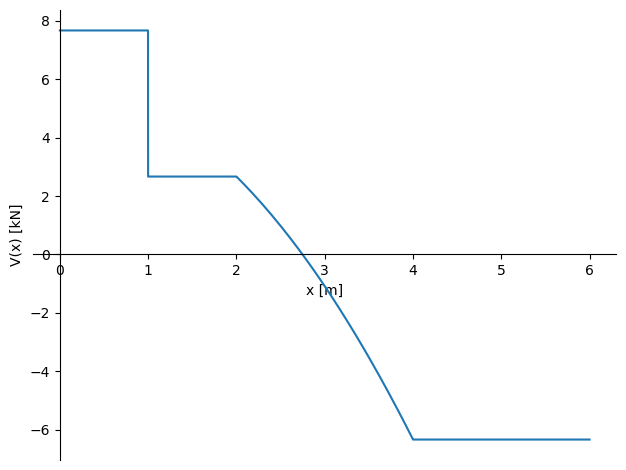

In [16]:
plot(V, x_xmin_xmax, xlabel='x [m]', ylabel='V(x) [kN]')

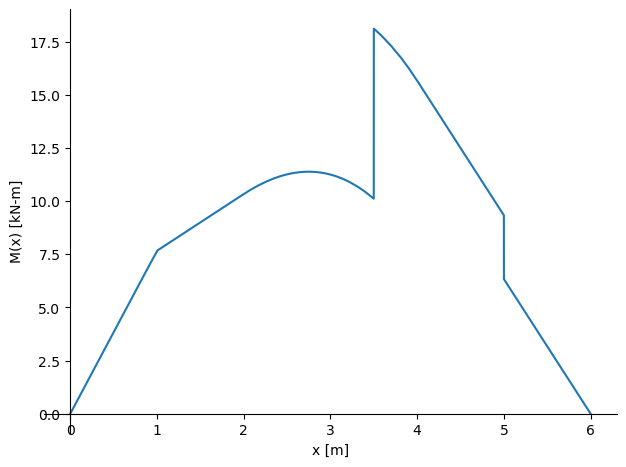

In [17]:
plot(M, x_xmin_xmax, xlabel='x [m]', ylabel='M(x) [kN-m]')

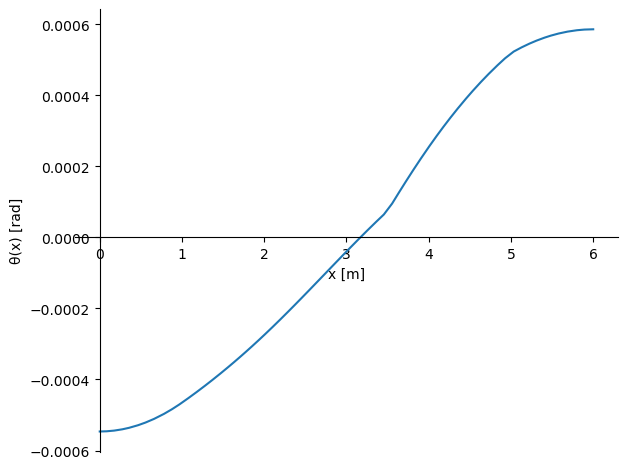

In [18]:
plot(t, x_xmin_xmax, xlabel='x [m]', ylabel='θ(x) [rad]')

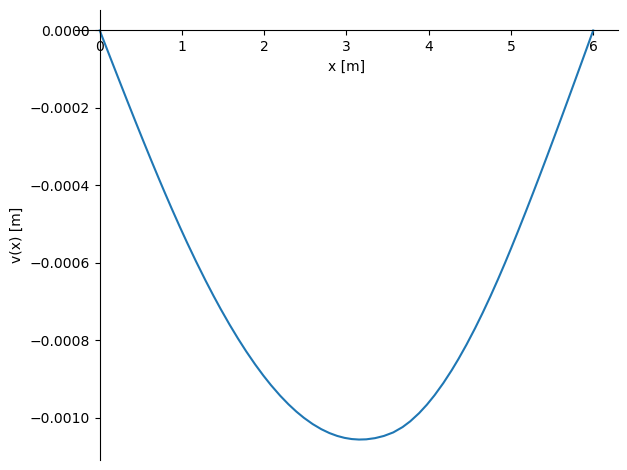

In [19]:
plot(v, x_xmin_xmax, xlabel='x [m]', ylabel='v(x) [m]')

### Se calculan las reacciones en la viga 

Reacción vertical en $x=0$ m:

In [20]:
print(f"Ry(x=0) = {float(+V.subs(x, 0))} kN")

Ry(x=0) = 7.666666666666667 kN


Reacción vertical en $x=L=6$ m:

In [21]:
print(f"Ry(x=6) = {float(-V.subs(x, 6-0.001))} kN")

Ry(x=6) = 6.333333333333333 kN
